Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extended Depth of Field (EDF) for 4D Microscopy Images
Testing EDF methods on denoised_1.4Pa_A1_20dec21_20xA_L2RA_FlatA_seq018 (2).tif, channel 1...
Testing Laplacian EDF...
Testing Sobel Variance EDF...
Testing Normalized Variance EDF...
Testing Multi-scale EDF...
Testing Map Fusion EDF...


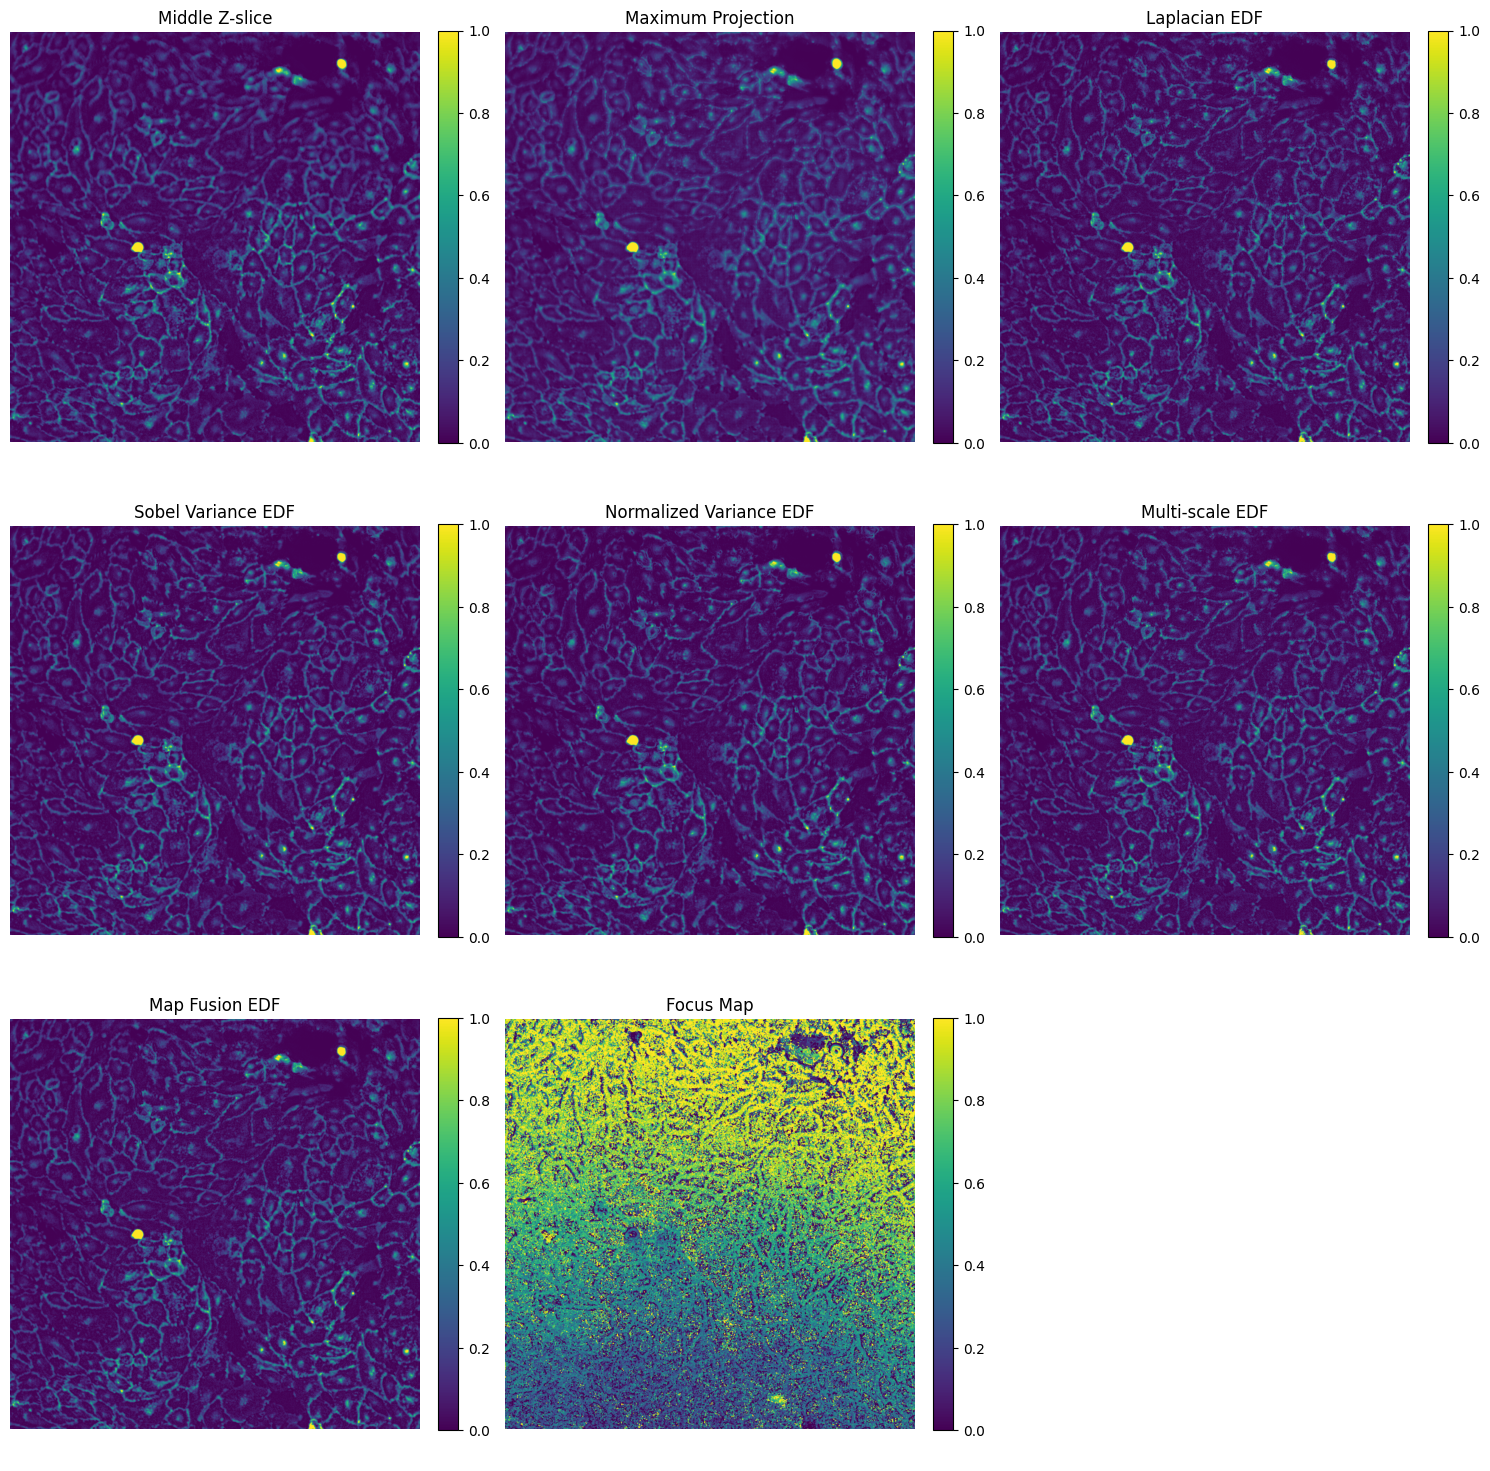


Available EDF methods:
1. Laplacian EDF (best for most confocal data)
2. Sobel Variance EDF (good for structures with clear edges)
3. Normalized Variance EDF (good for varying contrast regions)
4. Multi-scale EDF (combines information at different scales)
5. Map Fusion EDF (produces focus maps, good for complex structures)


In [ ]:
# Improved Extended Depth of Field (EDF) for Multichannel Confocal Z-Stacks
# Based on user's existing workflow but with enhanced projection methods

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
from skimage import io, filters, exposure, restoration, img_as_float, img_as_uint, measure
from skimage import morphology
from scipy import ndimage
import glob
import tifffile
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Define input and output paths
input_dir = '/content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/trial'
output_dir = '/content/drive/MyDrive/knowledge/University/Master/Thesis/Projected/trial'

# Define channel names
channel_names = ['Cadherins', 'Nuclei', 'Golgi']

# Create output directories for each channel
for channel_name in channel_names:
    channel_dir = os.path.join(output_dir, channel_name)
    os.makedirs(channel_dir, exist_ok=True)

# ======= UTILITY FUNCTIONS =======

def normalize_image(img):
    """Normalize image to 0-1 range"""
    img_min = np.min(img)
    img_max = np.max(img)
    if img_max > img_min:
        return (img - img_min) / (img_max - img_min)
    return img

def display_image_with_histogram(image, title="Image"):
    """Display an image with its histogram"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Display image
    im = ax1.imshow(image, cmap='viridis')
    ax1.set_title(title)
    ax1.axis('off')
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)

    # Display histogram
    ax2.hist(image.ravel(), bins=256, histtype='step', color='blue')
    ax2.set_title('Histogram')
    ax2.set_xlabel('Pixel Value')
    ax2.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# ======= BACKGROUND REMOVAL METHODS =======

def tophat_filter_background(image, radius=15):
    """
    Remove background using white top-hat filter

    Parameters:
    -----------
    image : numpy.ndarray
        Input image
    radius : int
        Radius of the disk-shaped structuring element

    Returns:
    --------
    numpy.ndarray
        Background-removed image
    """
    # Normalize input
    img = img_as_float(image)

    # Create structuring element (disk)
    selem = morphology.disk(radius)

    # Apply white top-hat filter (removes background while preserving foreground)
    tophat = morphology.white_tophat(img, selem)

    # Enhance contrast
    tophat = exposure.rescale_intensity(tophat)

    return tophat

# ======= IMPROVED PROJECTION METHODS =======

def advanced_edf_laplacian(image_stack, sigma=1.0, gauss_denoise=1.0):
    """
    Enhanced Extended Depth of Field using Laplacian-based focus measure

    Parameters:
    -----------
    image_stack : numpy.ndarray
        Stack of images with shape (z, y, x)
    sigma : float
        Sigma for Laplacian operator smoothing
    gauss_denoise : float
        Sigma for Gaussian denoising

    Returns:
    --------
    numpy.ndarray
        EDF projected image
    """
    # Convert to float and ensure correct range
    stack = img_as_float(image_stack)

    z_size, height, width = stack.shape
    result = np.zeros((height, width), dtype=np.float32)

    # Calculate focus measure using Laplacian
    focus_measures = np.zeros((z_size, height, width))

    for z in range(z_size):
        # Apply Gaussian filter to reduce noise
        if gauss_denoise > 0:
            blurred = filters.gaussian(stack[z], sigma=gauss_denoise)
        else:
            blurred = stack[z]

        # Apply Laplacian filter (detects edges/details)
        laplacian = np.abs(filters.laplace(blurred, ksize=3))

        # Apply small Gaussian to make the decision more robust
        if sigma > 0:
            focus_measures[z] = filters.gaussian(laplacian, sigma=sigma)
        else:
            focus_measures[z] = laplacian

    # Find the z-slice with maximum focus for each pixel
    best_z = np.argmax(focus_measures, axis=0)

    # Create output by taking pixels from best z-slices
    for z in range(z_size):
        mask = best_z == z
        result[mask] = stack[z][mask]

    return result

def edf_sobel_variance(image_stack, window_size=5, sigma=1.0):
    """
    Extended Depth of Field using Sobel gradient variance

    Parameters:
    -----------
    image_stack : numpy.ndarray
        Stack of images with shape (z, y, x)
    window_size : int
        Size of window for variance calculation
    sigma : float
        Sigma for Gaussian smoothing

    Returns:
    --------
    numpy.ndarray
        EDF projected image
    """
    # Convert to float
    stack = img_as_float(image_stack)

    z_size, height, width = stack.shape
    result = np.zeros((height, width), dtype=np.float32)

    # Calculate focus measure using Sobel variance
    focus_measures = np.zeros((z_size, height, width))

    for z in range(z_size):
        # Apply Gaussian filter to reduce noise
        blurred = filters.gaussian(stack[z], sigma=sigma)

        # Calculate Sobel gradients
        sobel_h = filters.sobel_h(blurred)
        sobel_v = filters.sobel_v(blurred)

        # Calculate gradient magnitude
        gradient_mag = np.sqrt(sobel_h**2 + sobel_v**2)

        # Calculate local variance (measure of texture/detail)
        focus_measures[z] = ndimage.uniform_filter(gradient_mag**2, size=window_size) - \
                           (ndimage.uniform_filter(gradient_mag, size=window_size))**2

    # Find the z-slice with maximum focus for each pixel
    best_z = np.argmax(focus_measures, axis=0)

    # Create output by taking pixels from best z-slices
    for z in range(z_size):
        mask = best_z == z
        result[mask] = stack[z][mask]

    return result

def edf_normalized_variance(image_stack, window_size=7):
    """
    Extended Depth of Field using normalized variance

    Parameters:
    -----------
    image_stack : numpy.ndarray
        Stack of images with shape (z, y, x)
    window_size : int
        Size of window for variance calculation

    Returns:
    --------
    numpy.ndarray
        EDF projected image
    """
    # Convert to float
    stack = img_as_float(image_stack)

    z_size, height, width = stack.shape
    result = np.zeros((height, width), dtype=np.float32)

    # Calculate focus measure using normalized variance
    focus_measures = np.zeros((z_size, height, width))

    for z in range(z_size):
        # Calculate local mean
        local_mean = ndimage.uniform_filter(stack[z], size=window_size)

        # Calculate local variance
        local_var = ndimage.uniform_filter(stack[z]**2, size=window_size) - local_mean**2

        # Normalize variance by local intensity to account for brightness variations
        # Add small epsilon to avoid division by zero
        epsilon = 1e-6
        focus_measures[z] = local_var / (local_mean + epsilon)

    # Find the z-slice with maximum focus for each pixel
    best_z = np.argmax(focus_measures, axis=0)

    # Create output by taking pixels from best z-slices
    for z in range(z_size):
        mask = best_z == z
        result[mask] = stack[z][mask]

    return result

def edf_multi_scale(image_stack, scales=[1, 3, 5], weights=[0.5, 0.3, 0.2]):
    """
    Multi-scale Extended Depth of Field that combines focus measures at different scales

    Parameters:
    -----------
    image_stack : numpy.ndarray
        Stack of images with shape (z, y, x)
    scales : list
        List of scales (sigmas) to use for Laplacian calculations
    weights : list
        Weights for each scale

    Returns:
    --------
    numpy.ndarray
        EDF projected image
    """
    # Normalize weights
    weights = np.array(weights) / np.sum(weights)

    # Convert to float
    stack = img_as_float(image_stack)

    z_size, height, width = stack.shape
    result = np.zeros((height, width), dtype=np.float32)

    # Initialize combined focus measure
    combined_focus = np.zeros((z_size, height, width))

    # Calculate focus measure at different scales and combine
    for i, (scale, weight) in enumerate(zip(scales, weights)):
        for z in range(z_size):
            # Apply Gaussian blur based on scale
            blurred = filters.gaussian(stack[z], sigma=scale/2)

            # Calculate Laplacian
            laplacian = np.abs(filters.laplace(blurred))

            # Add to combined focus measure with appropriate weight
            combined_focus[z] += weight * laplacian

    # Find the z-slice with maximum focus for each pixel
    best_z = np.argmax(combined_focus, axis=0)

    # Create output by taking pixels from best z-slices
    for z in range(z_size):
        mask = best_z == z
        result[mask] = stack[z][mask]

    return result

def edf_map_fusion(image_stack, sigma_list=[0.5, 1.0, 2.0]):
    """
    Extended Depth of Field with fusion of multiple focus maps

    Parameters:
    -----------
    image_stack : numpy.ndarray
        Stack of images with shape (z, y, x)
    sigma_list : list
        List of sigma values for different focus maps

    Returns:
    --------
    numpy.ndarray
        EDF projected image and focus map
    """
    # Convert to float
    stack = img_as_float(image_stack)

    z_size, height, width = stack.shape
    result = np.zeros((height, width), dtype=np.float32)

    # Create combined focus map
    combined_focus = np.zeros((z_size, height, width))

    # Calculate different focus maps and combine them
    for sigma in sigma_list:
        focus_map = np.zeros((z_size, height, width))

        for z in range(z_size):
            # Apply Gaussian filter to reduce noise
            blurred = filters.gaussian(stack[z], sigma=sigma)

            # Calculate Laplacian
            laplacian = np.abs(filters.laplace(blurred))

            # Smooth focus map slightly for better spatial consistency
            focus_map[z] = filters.gaussian(laplacian, sigma=1.0)

        # Add to combined focus map
        combined_focus += focus_map

    # Find the z-slice with maximum focus for each pixel
    best_z = np.argmax(combined_focus, axis=0)

    # Create output by taking pixels from best z-slices
    for z in range(z_size):
        mask = best_z == z
        result[mask] = stack[z][mask]

    # Return both result and focus map visualization
    focus_map_vis = best_z / (z_size - 1)  # Normalize to 0-1 range

    return result, focus_map_vis

def process_4d_microscopy_image(image, filename, method='laplacian'):
    """
    Process a 4D microscopy image with shape (channels, z-slices, height, width)
    Apply EDF projection with tophat background removal to each channel

    Parameters:
    -----------
    image : numpy.ndarray
        4D input image with shape (channels, z-slices, height, width)
    filename : str
        Original filename for naming the output
    method : str
        Projection method to use: 'laplacian', 'sobel', 'variance', 'multiscale', or 'fusion'

    Returns:
    --------
    dict
        Dictionary of processed images
    """
    print(f"  Processing 4D image with shape {image.shape}")

    # Normalize values if needed
    if image.dtype == np.float32 or image.dtype == np.float64:
        # Check if values are outside expected range
        if np.max(image) > 1.0 or np.min(image) < -1.0:
            print(f"  Normalizing image values from range [{np.min(image)}, {np.max(image)}] to [0, 1]")
            for c in range(image.shape[0]):
                for z in range(image.shape[1]):
                    image[c, z] = normalize_image(image[c, z])

    projections = {}
    focus_maps = {}

    # Process each channel with the selected EDF method and tophat background removal
    for channel in range(min(image.shape[0], len(channel_names))):
        # Get all z-slices for this channel
        channel_data = image[channel]

        try:
            # Apply tophat background removal to each z-slice
            processed_stack = np.zeros_like(channel_data, dtype=np.float32)
            for z in range(channel_data.shape[0]):
                processed_stack[z] = tophat_filter_background(channel_data[z])

            # Apply selected EDF projection method
            print(f"  Applying {method} EDF projection to {channel_names[channel]} channel...")

            if method == 'laplacian':
                proj = advanced_edf_laplacian(processed_stack, sigma=1.0, gauss_denoise=0.5)
                method_name = "laplacian_edf"

            elif method == 'sobel':
                proj = edf_sobel_variance(processed_stack, window_size=5, sigma=0.7)
                method_name = "sobel_variance_edf"

            elif method == 'variance':
                proj = edf_normalized_variance(processed_stack, window_size=7)
                method_name = "norm_variance_edf"

            elif method == 'multiscale':
                proj = edf_multi_scale(processed_stack, scales=[1, 3, 5], weights=[0.5, 0.3, 0.2])
                method_name = "multiscale_edf"

            elif method == 'fusion':
                proj, focus_map = edf_map_fusion(processed_stack, sigma_list=[0.5, 1.0, 2.0])
                focus_maps[f"{channel_names[channel]}_focus_map"] = focus_map
                method_name = "fusion_edf"

            else:
                # Default to laplacian method
                proj = advanced_edf_laplacian(processed_stack)
                method_name = "laplacian_edf"

            # Enhance contrast with adaptive histogram equalization
            enhanced = exposure.equalize_adapthist(proj, clip_limit=0.03)

            # Add sharpening
            enhanced = filters.unsharp_mask(enhanced, radius=2, amount=1.5)

            # Store result with channel name and method info
            projections[f"{channel_names[channel]}_{method_name}"] = enhanced

        except Exception as e:
            print(f"  Error processing channel {channel+1}: {e}")
            import traceback
            traceback.print_exc()

    return projections, focus_maps

def process_all_images(edf_method='laplacian'):
    """
    Process all 4D microscopy images in the input directory

    Parameters:
    -----------
    edf_method : str
        Projection method to use: 'laplacian', 'sobel', 'variance', 'multiscale', or 'fusion'

    Returns:
    --------
    list
        List of processed file paths
    """
    # Get all image files with common extensions (case insensitive)
    extensions = ['.tif', '.tiff', '.TIF', '.TIFF']
    all_files = []

    for ext in extensions:
        all_files.extend(glob.glob(os.path.join(input_dir, f'*{ext}')))

    if len(all_files) == 0:
        print(f"No image files found in {input_dir}")
        return []

    # Sort files to ensure consistent processing order
    all_files.sort()

    print(f"Found {len(all_files)} image files. Processing with {edf_method} EDF method...")

    processed_files = []

    # Process each image
    for idx, file_path in enumerate(all_files):
        filename = os.path.basename(file_path)
        print(f"Processing image {idx+1}/{len(all_files)}: {filename}")

        try:
            # Load the image
            image = tifffile.imread(file_path)

            # Print image info
            print(f"  Image shape: {image.shape}, dtype: {image.dtype}")

            # Skip if not 4D
            if len(image.shape) != 4:
                print(f"  Skipping - not a 4D image")
                continue

            # Process the 4D image
            projections, focus_maps = process_4d_microscopy_image(image, filename, method=edf_method)

            # Save each projection in its corresponding folder
            for proj_name, projection in projections.items():
                # Extract channel name from the projection name
                channel_name = proj_name.split('_')[0]

                # Create output filename that includes the full projection info
                base_name = os.path.splitext(filename)[0]
                output_filename = f"{base_name}_{proj_name}.tif"
                channel_dir = os.path.join(output_dir, channel_name)
                output_path = os.path.join(channel_dir, output_filename)

                # Convert to uint16 for saving
                if projection.dtype == np.float64 or projection.dtype == np.float32:
                    projection = img_as_uint(projection)

                # Save the projection
                tifffile.imwrite(output_path, projection)

                # Add to list of processed files
                processed_files.append(output_path)

            # Save focus maps if available
            for map_name, focus_map in focus_maps.items():
                # Create a "FocusMaps" directory
                focus_map_dir = os.path.join(output_dir, "FocusMaps")
                os.makedirs(focus_map_dir, exist_ok=True)

                # Create output filename
                base_name = os.path.splitext(filename)[0]
                output_filename = f"{base_name}_{map_name}.tif"
                output_path = os.path.join(focus_map_dir, output_filename)

                # Convert to uint16 for saving
                focus_map = img_as_uint(focus_map)

                # Save the focus map
                tifffile.imwrite(output_path, focus_map)

                # Add to list of processed files
                processed_files.append(output_path)

            print(f"  Saved {len(projections)} projections and {len(focus_maps)} focus maps")

        except Exception as e:
            print(f"  Error processing image {filename}: {e}")
            import traceback
            traceback.print_exc()
            continue

    return processed_files

# Function to test different projection methods on a sample image
def test_edf_methods(file_path, channel_idx=0):
    """
    Test different EDF methods on a specific file and channel

    Parameters:
    -----------
    file_path : str
        Path to the image file
    channel_idx : int
        Index of the channel to process

    Returns:
    --------
    dict
        Dictionary of results from different methods
    """
    print(f"Testing EDF methods on {os.path.basename(file_path)}, channel {channel_idx+1}...")

    # Load the image
    image = tifffile.imread(file_path)

    # Skip if not 4D
    if len(image.shape) != 4:
        print(f"Skipping - not a 4D image")
        return None

    # Get channel data
    channel_data = image[channel_idx]

    # Apply tophat background removal to each z-slice
    processed_stack = np.zeros_like(channel_data, dtype=np.float32)
    for z in range(channel_data.shape[0]):
        processed_stack[z] = tophat_filter_background(channel_data[z])

    # Apply different EDF methods
    results = {}

    # Original middle slice for comparison
    mid_z = processed_stack[processed_stack.shape[0] // 2]
    results["Middle Z-slice"] = mid_z

    # Maximum projection for comparison
    max_proj = np.max(processed_stack, axis=0)
    results["Maximum Projection"] = max_proj

    # Laplacian EDF
    print("Testing Laplacian EDF...")
    results["Laplacian EDF"] = advanced_edf_laplacian(processed_stack, sigma=1.0, gauss_denoise=0.5)

    # Sobel variance EDF
    print("Testing Sobel Variance EDF...")
    results["Sobel Variance EDF"] = edf_sobel_variance(processed_stack, window_size=5, sigma=0.7)

    # Normalized variance EDF
    print("Testing Normalized Variance EDF...")
    results["Normalized Variance EDF"] = edf_normalized_variance(processed_stack, window_size=7)

    # Multi-scale EDF
    print("Testing Multi-scale EDF...")
    results["Multi-scale EDF"] = edf_multi_scale(processed_stack, scales=[1, 3, 5], weights=[0.5, 0.3, 0.2])

    # Map fusion EDF
    print("Testing Map Fusion EDF...")
    fusion_result, focus_map = edf_map_fusion(processed_stack, sigma_list=[0.5, 1.0, 2.0])
    results["Map Fusion EDF"] = fusion_result
    results["Focus Map"] = focus_map

    return results

def display_comparative_results(results):
    """
    Display comparative results from different EDF methods

    Parameters:
    -----------
    results : dict
        Dictionary of results from different methods
    """
    num_methods = len(results)

    # Organize the visualization based on number of methods
    if num_methods <= 3:
        fig, axes = plt.subplots(1, num_methods, figsize=(5*num_methods, 5))
    else:
        cols = 3
        rows = (num_methods + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
        axes = axes.flatten()

    # If there's only one result, make axes iterable
    if num_methods == 1:
        axes = [axes]

    # Plot each result
    for i, (method_name, result) in enumerate(results.items()):
        # Skip if we have more methods than axes
        if i >= len(axes):
            break

        # Enhance contrast for better visualization
        p_low, p_high = np.percentile(result, (0.1, 99.9))
        img_display = exposure.rescale_intensity(result, in_range=(p_low, p_high))

        # Display image
        im = axes[i].imshow(img_display, cmap='viridis')
        axes[i].set_title(method_name)
        axes[i].axis('off')
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

    # Hide any unused subplots
    for i in range(num_methods, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    print("Extended Depth of Field (EDF) for 4D Microscopy Images")
    print("======================================================")

    # Ask user if they want to test methods on a sample first
    test_first = input("Do you want to test different EDF methods on a sample image first? (y/n): ").lower() == 'y'

    if test_first:
        # Get list of available files
        extensions = ['.tif', '.tiff', '.TIF', '.TIFF']
        all_files = []
        for ext in extensions:
            all_files.extend(glob.glob(os.path.join(input_dir, f'*{ext}')))

        if not all_files:
            print(f"No image files found in {input_dir}")
        else:
            # Select first file as sample
            sample_file = all_files[0]

            # Run tests
            results = test_edf_methods(sample_file, channel_idx=0)

            if results:
                # Display results
                display_comparative_results(results)

                # Ask which method to use for processing all files
                print("\nAvailable EDF methods:")
                print("1. Laplacian EDF (best for most confocal data)")
                print("2. Sobel Variance EDF (good for structures with clear edges)")
                print("3. Normalized Variance EDF (good for varying contrast regions)")
                print("4. Multi-scale EDF (combines information at different scales)")
                print("5. Map Fusion EDF (produces focus maps, good for complex structures)")

                while True:
                    try:
                        method_choice = int(input("Enter your choice (1-5): "))
                        if 1 <= method_choice <= 5:
                            break
                        else:
                            print("Please enter a number between 1 and 5.")
                    except ValueError:
                        print("Please enter a valid number.")

                # Map choice to method
                method_map = {
                    1: 'laplacian',
                    2: 'sobel',
                    3: 'variance',
                    4: 'multiscale',
                    5: 'fusion'
                }

                edf_method = method_map[method_choice]
            else:
                # Default to laplacian if testing failed
                print("Testing failed. Defaulting to Laplacian EDF.")
                edf_method = 'laplacian'
    else:
        # Default method
        print("\nAvailable EDF methods:")
        print("1. Laplacian EDF (best for most confocal data)")
        print("2. Sobel Variance EDF (good for structures with clear edges)")
        print("3. Normalized Variance EDF (good for varying contrast regions)")
        print("4. Multi-scale EDF (combines information at different scales)")
        print("5. Map Fusion EDF (produces focus maps, good for complex structures)")

        while True:
            try:
                method_choice = 1
                if 1 <= method_choice <= 5:
                    break
                else:
                    print("Please enter a number between 1 and 5.")
            except ValueError:
                print("Please enter a valid number.")

        # Map choice to method
        method_map = {
            1: 'laplacian',
            2: 'sobel',
            3: 'variance',
            4: 'multiscale',
            5: 'fusion'
        }

        edf_method = method_map[method_choice]

    # Process all images with selected method
    print(f"\nProcessing all images with {edf_method} EDF method...")
    processed_files = process_all_images(edf_method=edf_method)

    # Display results
    if processed_files:
        print(f"\nSuccessfully processed {len(processed_files)} projections:")
        for output_file in processed_files[:5]:  # Show first 5
            print(f"  - {os.path.basename(output_file)}")
        if len(processed_files) > 5:
            print(f"  ... and {len(processed_files) - 5} more")

        # Try to display the first result in the notebook
        try:
            from IPython.display import Image
            print("\nDisplaying first result:")
            display(Image(processed_files[0]))
        except Exception as e:
            print(f"Couldn't display image: {e}")
    else:
        print("No images were processed successfully.")